# Identification of the Theodorsen unsteady lift 

## Data generation

As for the previous case the data is generated through a python script. Since the objective is to identify the Theodorsen function through its input-output response the classical model for a monochromatic oscillation cannot be used, since a wide spectrum input has to be prefered. The data-generation code uses then a linear approximation of the Theodorsen function obtained by balanced truncation in {cite}`brunton2013empirical`. 

[]

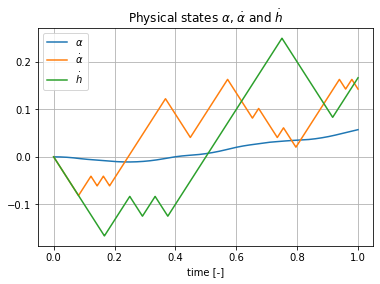

In [1]:
import numpy as np
import control
import Theodorsen_control as theodorsen
from signals import prbs
import matplotlib.pyplot as plt

a = 1/2  # pitch axis wrt to 1/2-chord
b = 1.  # half-chord length of the airfoil
# default values of C_1 and C_2 used
airfoil = theodorsen.AirfoilGeometry(a=a, b=b)

# THEDORSEN MODEL

# the balanced truncation Theodorsen function approximation
theodorsen_function_sys = theodorsen.theodorsen_function_balanced_truncation_ss()

# state-space system with both α" and h" as inputs
theodorsen_full_sys = theodorsen.unsteady_lift_ss(
    airfoil, theodorsen_function_sys)

# INPUT SIGNALS

NT = 20000 # number of time steps
t = np.linspace(0, 1, NT)
dt = 400 * t[-1] / NT

amplitude= 1
seed = np.array([0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0])
alpha_ddot = prbs(t, dt, min = -amplitude, max = amplitude, seed = seed)
h_ddot = prbs(t, 2 * dt, min = -amplitude, max = amplitude, seed = seed)
u_MISO = np.vstack((h_ddot.T, alpha_ddot.T))

# TIME RESPONSE

X0 = np.array([0,0,0,0,
              0.0,   # h_dot(0)
              0.0, # alpha(0)
              0.0])   # alpha_dot(0)

output = control.forced_response(
    theodorsen_full_sys, T=t, U=u_MISO, X0 = X0)

# TIME RESPONSE POSTPROCESSING

data = theodorsen.TheodorsenTimeResponse(
    output, inputs='both', sys=theodorsen_full_sys)

fig, ax = plt.subplots()
ax.plot(t, data.alpha)
ax.plot(t, data.alpha_dot)
ax.plot(t, data.h_dot)
ax.grid(True)
ax.set_title(r'Physical states $\alpha$, $\dot \alpha$ and $\dot h$')
ax.set_xlabel('time [-]')
ax.legend([r'$\alpha$', r'$\dot \alpha$', r'$\dot h$'])
plt.plot()

## Model regression

As stated in <span style="color: red;">section</span> we want to fit a model in the form:
```{math}
    C_L(t) = \Theta(t)\xi
```
where $\Theta$ is a library of linear and nonlinear functions and $\xi$ are the corresponding coefficients. The data obtained in the previous section is divided equally between a training set and a test set, such that

In [2]:
# Training set
X_train = np.stack([data.alpha_e[:NT // 2],
                    data.alpha_dot[:NT // 2]] , axis = -1) # physical states of the system
CL_train = data.C_L[:NT // 2] # output of the system

# Test set
X_test = np.stack([data.alpha_e[NT // 2:],
                   data.alpha_dot[NT // 2:]], axis = -1)
CL_test = data.C_L[NT // 2:]

Since we know that the possibly nonlinear part of the Theodorsen model lies in the circulatory lift only, and that in general the added mass term behaves linearly, we decided to only fit the first one, assumng as a first moment that the added mass coefficients are known.

In [3]:
CL_train -= (theodorsen_full_sys.D @ u_MISO[:,:NT // 2]).T
CL_test -= (theodorsen_full_sys.D @ u_MISO[:, NT // 2:]).T

Since SINDy is based on the machine learning library `sklearn` it is possible to substitute the derivatives of the classical SINDy models with the $C_l$ without any modification of the underlying code. The set up for the regression is then:

In [4]:
import pysindy as ps

expansionDegree = 4

# SETTING UP SINDy 
optimizer = ps.optimizers.stlsq.STLSQ(threshold = 0.1, alpha = 1e-06, max_iter = 50)
library = ps.feature_library.polynomial_library.PolynomialLibrary(degree = expansionDegree) # standard polynomial library

model = ps.SINDy(optimizer = optimizer, 
			     feature_library = library,
			     feature_names = ['alpha_e', 'alpha_dot']) 
t = data.t
classicalModel = model.fit(X_train, t = t[1] - t[0], x_dot = CL_train)
CL_classic_SINDy_train = model.model.predict(X_train)
CL_classic_SINDy_test = model.model.predict(X_test)
classicalModel.print()

(alpha_e)' = 3.755 alpha_e + 2.584 alpha_dot + 8.309 alpha_e^2 + -3.777 alpha_e alpha_dot + -2.090 alpha_dot^2 + 55.580 alpha_e^3 + -16.590 alpha_e^2 alpha_dot + -51.143 alpha_e alpha_dot^2 + 55.364 alpha_dot^3 + 151.532 alpha_e^4 + -100.224 alpha_e^3 alpha_dot + -197.264 alpha_e^2 alpha_dot^2 + 422.948 alpha_e alpha_dot^3 + -76.028 alpha_dot^4


The results for the classical polynomial library can be compared with those for an orthogonal and othonormal base

In [5]:
from PolynomialChaos import *

aPC = PolynomialChaos(
     X_train,
     expansionDegree = expansionDegree,
     numberOfInputs = 2)
aPC.ComputeCoefficients(threshold =0.01, normalize = False)
coefficients = aPC.coefficients
AlphaMatrix = aPC.AlphaMatrix

LibraryList = GenerateLibraryList(
     expansionDegree=expansionDegree,
     coefficients = coefficients,
     AlphaMatrix = AlphaMatrix)

# Expansion of degree 2

aPC2 = PolynomialChaos(
     X_train,
     expansionDegree = expansionDegree-2,
     numberOfInputs = 2)
aPC2.ComputeCoefficients(threshold =0.01, normalize = False)
coefficients2 = aPC2.coefficients
AlphaMatrix2 = aPC2.AlphaMatrix

LibraryList2 = GenerateLibraryList(
     expansionDegree=expansionDegree-2,
     coefficients = coefficients,
     AlphaMatrix = AlphaMatrix2)

aPC_norm = PolynomialChaos(
     X_train,
     expansionDegree = expansionDegree,
     numberOfInputs = 2)
aPC_norm.ComputeCoefficients(threshold =0.01, normalize = True)
coefficients_norm = aPC_norm.coefficients
 
LibraryList_norm = GenerateLibraryList(
     expansionDegree=expansionDegree,
     coefficients = coefficients_norm,
     AlphaMatrix = AlphaMatrix)

optimizer = ps.optimizers.stlsq.STLSQ(threshold = 0.01, alpha = 1e-05, max_iter = 50)
library_orth = ps.feature_library.custom_library.CustomLibrary(LibraryList)
library_orthnorm = ps.feature_library.custom_library.CustomLibrary(LibraryList_norm)
library_orth2 = ps.feature_library.custom_library.CustomLibrary(LibraryList2)

model = ps.SINDy(optimizer = optimizer, 
			     feature_library = library_orth,
			     feature_names = ['alpha_e', 'alpha_dot']) 
OrthModel = model.fit(X_train, t = t[1] - t[0], x_dot = CL_train) # Orthogonal model
CL_SINDy_train = model.model.predict(X_train)
CL_SINDy_test = model.model.predict(X_test)

model = ps.SINDy(optimizer = optimizer, 
			     feature_library = library_orth2,
			     feature_names = ['alpha_e', 'alpha_dot']) 
OrthModel2 = model.fit(X_train, t = t[1] - t[0], x_dot = CL_train) # Orthogonal model
CL_SINDy_train2 = model.model.predict(X_train)
CL_SINDy_test2 = model.model.predict(X_test)

print('-------- Orthogonal model order 4 --------\n')
OrthModel.print()

model = ps.SINDy(optimizer = optimizer, 
			     feature_library = library_orthnorm,
			     feature_names = ['alpha_e', 'alpha_dot']) 
OrthNormModel = model.fit(X_train, t = t[1] - t[0], x_dot = CL_train) # Orthonormal model
CL_norm_SINDy_train = model.model.predict(X_train)
CL_norm_SINDy_test = model.model.predict(X_test)

print('\n----------- Orthonormal model -----------\n')
OrthNormModel.print()

-------- Orthogonal model order 4 --------

(alpha_e)' = -0.265 f0() + 3.155 f1(alpha_e,alpha_dot) + 2.975 f2(alpha_e,alpha_dot) + 1.519 f3(alpha_e,alpha_dot) + -2.350 f4(alpha_e,alpha_dot) + 0.472 f5(alpha_e,alpha_dot)

----------- Orthonormal model -----------

(alpha_e)' = -0.272 f0() + 0.143 f1(alpha_e,alpha_dot) + 0.185 f2(alpha_e,alpha_dot)


We can see immediatedly that the orthonormal model has retained only the linear terms, while the classical and the non normalised orthogonal arrived up to degree 4. It is not obvious why this must be the case, but looking at the form of the orthogonormal polynomials we can clearly see that the coefficient of the leading term increases very fast:

In [6]:
aPC_norm.printFeatureNames(['a_e', 'a_dot'])

f0: 1
f1: (2.102 + 22.247a_e)
f2: (-0.217 + 16.117a_dot)
f3: (2.266 + 77.324a_e + 460.373a_e^2)
f4: (2.102 + 22.247a_e)(-0.217 + 16.117a_dot)
f5: (-1.292 + -12.909a_dot + 363.578a_dot^2)
f6: (2.513 + 187.224a_e + 2644.582a_e^2 + 10028.037a_e^3)
f7: (2.266 + 77.324a_e + 460.373a_e^2)(-0.217 + 16.117a_dot)
f8: (0.842 + -28.874a_dot + -417.955a_dot^2 + 6448.687a_dot^3)
f9: (2.102 + 22.247a_e)(-1.292 + -12.909a_dot + 363.578a_dot^2)
f10: (1.190 + 39.429a_dot + -851.396a_dot^2 + -10134.861a_dot^3 + 127204.928a_dot^4)
f11: (2.102 + 22.247a_e)(0.842 + -28.874a_dot + -417.955a_dot^2 + 6448.687a_dot^3)
f12: (2.266 + 77.324a_e + 460.373a_e^2)(-1.292 + -12.909a_dot + 363.578a_dot^2)
f13: (2.513 + 187.224a_e + 2644.582a_e^2 + 10028.037a_e^3)(-0.217 + 16.117a_dot)
f14: (2.138 + 310.551a_e + 8460.272a_e^2 + 77494.122a_e^3 + 226032.961a_e^4)


This is due to the fact that the norm of the polynomials of higher order is decreasing rapidly due to the small nature of the variables $\alpha_e$ and $\dot\alpha$. That is why increasingly large coefficients appear in the other models, while they shrink very rapidly in the normalised case. By comparing the results we can see immediately that the fourth order polynomials critically overfit on the training data and cannot predict the $C_l$ for more than a fifth of the test set. While the second order polynomial perform better, the most effective one is the first order normalised one, that starts to diverge only at the very end.

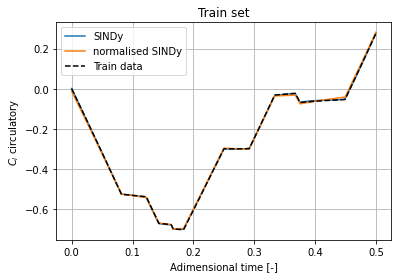

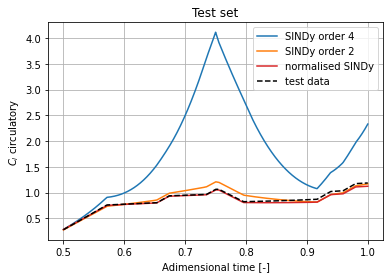

In [7]:
fig, ax = plt.subplots()
ax.plot(t[:NT // 2], CL_SINDy_train)
ax.plot(t[:NT // 2], CL_norm_SINDy_train)
ax.plot(t[:NT // 2], CL_train, 'k--')
ax.set_xlabel('Adimensional time [-]')
ax.set_ylabel(r'$C_l$ circulatory')
ax.set_title('Train set')
ax.legend([ 'SINDy', 'normalised SINDy', 'Train data'])
ax.grid(True)


fig, ax = plt.subplots()
ax.plot(t[NT // 2:], CL_SINDy_test)
ax.plot(t[NT // 2:], CL_SINDy_test2)
ax.plot(t[NT // 2:], CL_norm_SINDy_test, 'tab:red')
ax.plot(t[NT // 2:], CL_test, 'k--')
ax.set_xlabel('Adimensional time [-]')
ax.set_ylabel(r'$C_l$ circulatory')
# ax.set_ylim([-0.0, 2])
ax.set_title('Test set')
ax.legend(['SINDy order 4', 'SINDy order 2', 'normalised SINDy', 'test data'])
ax.grid(True)

## Conclusions

It can be seen that the indentified model of the circulatory part of the lift coefficient is, as a first approximation, linear. In fact for small input signals the nonlinear coefficients in the form of higher powers of the states have such a small norm that, even when included in the model, tend to have little effect make the model overfit to the training data. 

Such a model thus cannot in fact identify significantly the effect of the theodorsen model in terms of delay in the change angle of attack or vertical velocity, which is a fundamental aspect of the original model. 